In [1]:
import numpy as np
import pandas as pd

In [2]:
energy = pd.read_csv('/kaggle/input/energy-consumption-generation-prices-and-weather/energy_dataset.csv')
weather = pd.read_csv('/kaggle/input/energy-consumption-generation-prices-and-weather/weather_features.csv')

In [3]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [4]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [5]:
energy.drop(['generation hydro pumped storage aggregated', 'forecast wind offshore eday ahead'], axis=1, inplace=True)

In [6]:
energy['time'] = pd.to_datetime(energy['time'])
weather['time'] = pd.to_datetime(weather['dt_iso'])
weather.drop('dt_iso', axis=1, inplace=True)

In [7]:
weather.drop(['weather_description', 'weather_icon'], axis=1, inplace=True)

Weather icon is very similar to weather main which we will use as categories. Weather description could be feature engineered but we already have many data and most probably results would be close to weather main. So we dropped them.

In [8]:
weather['weather_main'].value_counts()

clear           82685
clouds          68055
rain            17391
mist             3908
fog              2506
drizzle          1724
thunderstorm     1041
haze              435
dust              347
snow              270
smoke              33
squall              1
Name: weather_main, dtype: int64

In [9]:
dummies = pd.get_dummies(weather['weather_main'], drop_first=True).drop('squall', axis=1)
weather = pd.concat([weather, dummies], axis=1).drop('weather_main', axis=1)

There is only 1 squall, we may drop that column because it is almost a column full of zeros.

In [10]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 24 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   city_name     178396 non-null  object 
 1   temp          178396 non-null  float64
 2   temp_min      178396 non-null  float64
 3   temp_max      178396 non-null  float64
 4   pressure      178396 non-null  int64  
 5   humidity      178396 non-null  int64  
 6   wind_speed    178396 non-null  int64  
 7   wind_deg      178396 non-null  int64  
 8   rain_1h       178396 non-null  float64
 9   rain_3h       178396 non-null  float64
 10  snow_3h       178396 non-null  float64
 11  clouds_all    178396 non-null  int64  
 12  weather_id    178396 non-null  int64  
 13  time          178396 non-null  object 
 14  clouds        178396 non-null  uint8  
 15  drizzle       178396 non-null  uint8  
 16  dust          178396 non-null  uint8  
 17  fog           178396 non-null  uint8  
 18  haze

In [11]:
city_names = weather.city_name.unique()
city_names

array(['Valencia', 'Madrid', 'Bilbao', ' Barcelona', 'Seville'],
      dtype=object)

We have the weather data of 5 cities. We may group them by time and unstack the cities. Which means we will have time as index and 22 column of weather data for each city. Then we can join all cities together and join them with energy data.

In [12]:
cities= {}
for i in city_names:
    cities[i] = weather[weather['city_name'] == i].drop('city_name', axis=1).add_prefix(i+'_').rename(columns={i+'_time':'time'})

In [13]:
for i in cities:
    energy = pd.merge(energy, cities[i], on='time')

In [14]:
df = energy.sort_values(by=['time']).drop('time', axis=1)

In [15]:
df.isna().sum().sum()

401

In [16]:
df.dropna(inplace=True)

In [17]:
train_len = int(len(df.index)*.75)

In [18]:
train = df[0:train_len]
test = df[train_len:len(df.index)]

We didn't split randomly because we need our test case to be realistic. As we will try to guess future energy consumption with the data of past, we should split the test dataset from the ned of the data we have to make it realistic.

In [19]:
y_train = train['total load actual']
X_train = train.drop(['total load actual', 'price actual'], axis=1)

In [20]:
y_test = test['total load actual']
X_test = test.drop(['total load actual', 'price actual'], axis=1)

We will try to produce a model that can predict the total load. However we also dropped the price actual columns because it is also unknown for future. So keeping it in X would be cheating. On another analysis we may also try to predict the actual price.

In [21]:
from sklearn.ensemble import RandomForestRegressor

In [22]:
rfr = RandomForestRegressor(n_estimators=100, bootstrap=True, random_state=2)
rfr.fit(X_train,y_train)

RandomForestRegressor(random_state=2)

In [23]:
pred = rfr.predict(X_test)

In [24]:
from sklearn.metrics import mean_squared_error

In [25]:
print(mean_squared_error(y_test, pred)**.5)

401.05576162474694


In [26]:
print(mean_squared_error(df['total load actual'], df['total load forecast'])**.5)

451.32953059636907


Root mean square error of the model we produced is about 400. The prediction which is already in the dataset has a root mean square error of 450. So we did an improvement to the existing model. Actually we also used that model inside our model because prediction of that model is in our X ('total load forecast' named column). So we feed that prediction to our model, too. But our model improves that model as rmse is about 88% of it.  
  
  Our model has lower error relative to the predictions in the dataset however we should also examine if the rmse of our model is good enough.

<AxesSubplot:ylabel='Frequency'>

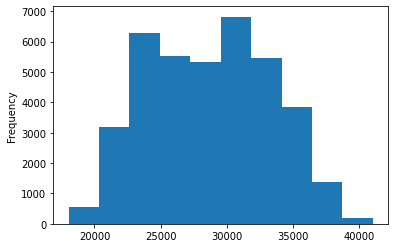

In [27]:
df['total load actual'].plot.hist()

As we can see from the histogram mean is about 30_000 and range is about 20_000 so 400 rmse is a great.